In [1]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create widgets for username, password, and login button
username_widget = widgets.Text(
    value='',
    placeholder='Enter username',
    description='Username:',
    disabled=False
)

password_widget = widgets.Password(
    value='',
    placeholder='Enter password',
    description='Password:',
    disabled=False
)

login_button = widgets.Button(description="Login")
output = widgets.Output()

# Define the function that runs when the button is clicked
def on_login_clicked(b):
    with output:
        clear_output()
        # Get input values
        username = username_widget.value
        password = password_widget.value
        # Check credentials 
        if username == "my_username" and password == "my_password":
            print("Login successful! You now have access to the notebook functionality.")
        else:
            print("Incorrect username or password. Please try again.")

login_button.on_click(on_login_clicked)

# Display the login interface
display(username_widget, password_widget, login_button, output)

Text(value='', description='Username:', placeholder='Enter username')

Password(description='Password:', placeholder='Enter password')

Button(description='Login', style=ButtonStyle())

Output()

Welcome to the ML Energy Prediction Project!

We theorize that weather plays a crucial part of energy consumption and aim to create an ML product that not only shows the correlation between the two, but also uses the temperature and other temporal features to aid in energy prediction. The reason we came to this conclusion is based on years of lived experience in extreme climates. If it is hot outside (80 F+), the energy bill goes up from using the AC! If it is moderate outside (50 F - 80F), the energy bill and thus usage, goes down.

Our first step in proving our hypothesis is by cleaning our Kaggle data sets below. This first cell removes the unnecessary rows from the raw energy consumption data set so the Datetime column will line up with the temperature data set. 

In [17]:
import csv
from datetime import datetime

def mass_delete_rows(input_file, output_file, condition=None):

    with open(input_file, 'r', newline='', encoding='utf-8') as infile:
        reader = csv.reader(infile)
        header = next(reader)  # Read the header
        rows = list(reader)

    # Filter rows
    filtered_rows = []
    for row in rows:
        if condition and condition(row):
            continue
        filtered_rows.append(row)

    # Write to the output file
    with open(output_file, 'w', newline='', encoding='utf-8') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(header)  # Write the header
        writer.writerows(filtered_rows)

if __name__ == "__main__":
    # Example usage
    input_csv = "data/DUQ_hourly_RAW_DATA.csv"
    output_csv = "data/Duquesne_Light_hourly_filtered.csv"

    # Delete rows not within the date range '2012-10-01' to '2017-11-30'
    def condition_to_delete(row):
        try:
            # Assuming the datetime is in the first column (index 0)
            date = datetime.strptime(row[0], "%Y-%m-%d %H:%M:%S")
            start_date = datetime(2012, 10, 1)
            end_date = datetime(2017, 11, 30)
            return not (start_date <= date <= end_date)
        except ValueError:
            # Skip rows with invalid datetime format
            return True

    mass_delete_rows(input_csv, output_csv, condition=condition_to_delete)

    print(f"Rows have been filtered and written to {output_csv}")

Rows have been filtered and written to data/Duquesne_Light_hourly_filtered.csv


The next cell will clean up the unneeded columns from the raw temperature data set. Both data sets are for the same period of time (10/01/2012 - 11/30/2017) and set in Pittsburgh, PA. The reason for choosing this data set is twofold. First, Pittsburgh is a city with four distinct seasons and lends itself well to a ML model is this sort. Second, it was the only city we could find hourly data of both energy usage and temperature for a long period of time.

In [25]:
import csv

def filter_csv_columns(file_path, columns_to_keep, output_file):
    with open(file_path, 'r') as infile, open(output_file, 'w', newline='') as outfile:
        reader = csv.DictReader(infile)
        
        # Create output fieldnames, renaming "Pittsburgh" to "Temperature_K"
        output_fieldnames = []
        for col in columns_to_keep:
            if col == "Pittsburgh":
                output_fieldnames.append("Temperature_K")
            else:
                output_fieldnames.append(col)

        writer = csv.DictWriter(outfile, fieldnames=output_fieldnames)
        writer.writeheader()

        # Write rows with the appropriate column renaming
        for row in reader:
            new_row = {}
            for col in columns_to_keep:
                if col in row:
                    if col == "Pittsburgh":
                        new_row["Temperature_K"] = row[col]
                    else:
                        new_row[col] = row[col]
            writer.writerow(new_row)

# Define file paths and columns to keep
input_file = 'data/temperature_RAW_DATA.csv'
output_file = 'data/filtered_temperature_Pittsburgh.csv'
columns_to_keep = ['Datetime', 'Pittsburgh']

# Filter the CSV file and rename "Pittsburgh" to "Temperature_K"
filter_csv_columns(input_file, columns_to_keep, output_file)

print(f"Filtered columns saved to {output_file}")


Filtered columns saved to data/filtered_temperature_Pittsburgh.csv


The following cell will combine the two filtered data sets into one data set using the Datetime and add several new rows that will help us explore the data and see if our hunch on energy usage and temperature is correct. 

In [1]:
import pandas as pd


# Load the energy consumption dataset
data = pd.read_csv("data/Duquesne_Light_hourly_filtered.csv")
print(type(data))
# Strip whitespace from column names
data.columns = data.columns.str.strip()

# Convert 'Datetime' column to datetime and set it as the index
data['Datetime'] = pd.to_datetime(data['Datetime'])
data.set_index('Datetime', inplace=True)

# Rename the 'DUQ_MW' column 
data.rename(columns={'DUQ_MW': 'Energy_Consumption'}, inplace=True)

# Extract features from the index
data['Hour'] = data.index.hour
data['Day_of_Week'] = data.index.dayofweek
data['Month'] = data.index.month
data['Day'] = data.index.day  # Day of the month (1-31)

# Create 'Date' column
data['Date'] = data.index.date
# Ensure 'Date' is in ISO 8601 format
data['Date'] = data['Date'].apply(lambda x: x.isoformat() if not isinstance(x, str) else x)

# Create 'Season' column
data['Season'] = data['Month'].apply(
    lambda x: 'Winter' if x in [12, 1, 2] else
              'Spring' if x in [3, 4, 5] else
              'Summer' if x in [6, 7, 8] else 'Fall'
)

# Map the seasons to numerical values
season_mapping = {'Winter': 1, 'Spring': 2, 'Summer': 3, 'Fall': 4}
data['Season'] = data['Season'].map(season_mapping)

# Load the temperature dataset
temperature_data = pd.read_csv("data/filtered_temperature_Pittsburgh.csv")

# Convert 'Datetime' column to datetime
temperature_data['Datetime'] = pd.to_datetime(temperature_data['Datetime'])

# Convert temperature from Kelvin to Fahrenheit
# Formula: °F = (K - 273.15) * 9/5 + 32
temperature_data['Temperature_F'] = (temperature_data['Temperature_K'] - 273.15) * 9/5 + 32

# Drop the original Kelvin column if no longer needed
temperature_data.drop(columns=['Temperature_K'], inplace=True)

# Set 'Datetime' as the index for temperature data
temperature_data.set_index('Datetime', inplace=True)

# Merge temperature data with energy consumption data
data = data.merge(temperature_data, left_index=True, right_index=True, how='left')

# Feature Engineering: Temperature Deviation
data['Temp_Deviation'] = data['Temperature_F'] - data['Temperature_F'].mean()

# Verify the merged data
print(data[['Energy_Consumption', 'Temperature_F', 'Temp_Deviation', 'Hour', 'Day_of_Week', 'Month', 'Day', 'Season']].head())

# Save the updated dataset 
data.to_csv("data/updated_energy_data_with_temperature.csv", index=True)
print(type(data))


<class 'pandas.core.frame.DataFrame'>
                     Energy_Consumption  Temperature_F  Temp_Deviation  Hour  \
Datetime                                                                       
2012-12-31 01:00:00              1556.0         29.840      -21.789178     1   
2012-12-31 02:00:00              1509.0         29.840      -21.789178     2   
2012-12-31 03:00:00              1479.0         29.282      -22.347178     3   
2012-12-31 04:00:00              1468.0         28.886      -22.743178     4   
2012-12-31 05:00:00              1488.0         28.868      -22.761178     5   

                     Day_of_Week  Month  Day  Season  
Datetime                                              
2012-12-31 01:00:00            0     12   31       1  
2012-12-31 02:00:00            0     12   31       1  
2012-12-31 03:00:00            0     12   31       1  
2012-12-31 04:00:00            0     12   31       1  
2012-12-31 05:00:00            0     12   31       1  
<class 'pandas.c

The next cell is needed to scale the data so it can be properly measured for the following graphs.

In [2]:
from sklearn.preprocessing import MinMaxScaler

# Ensure 'Energy_Consumption' and 'Temperature_F' exist in the data
if 'Energy_Consumption' in data.columns and 'Temperature_F' in data.columns:
    if data['Energy_Consumption'].shape[0] > 0 and data['Temperature_F'].shape[0] > 0:
        # Initialize the scaler
        scaler = MinMaxScaler()

        # Scale the energy consumption and temperature columns
        data[['Energy_Consumption', 'Temperature_F']] = scaler.fit_transform(
            data[['Energy_Consumption', 'Temperature_F']]
        )
    else:
        print("Error: One of the columns is empty. Check your data processing.")
else:
    print("Error: Required columns ('Energy_Consumption' or 'Temperature_F') are missing.")

#Display the first few rows
print(data[['Energy_Consumption', 'Temperature_F']].head(50))

                     Energy_Consumption  Temperature_F
Datetime                                              
2012-12-31 01:00:00            0.279814       0.396138
2012-12-31 02:00:00            0.255550       0.396138
2012-12-31 03:00:00            0.240062       0.390687
2012-12-31 04:00:00            0.234383       0.386818
2012-12-31 05:00:00            0.244708       0.386643
2012-12-31 06:00:00            0.273103       0.364574
2012-12-31 07:00:00            0.322148       0.342505
2012-12-31 08:00:00            0.364481       0.342505
2012-12-31 09:00:00            0.370676       0.375740
2012-12-31 10:00:00            0.388745       0.364134
2012-12-31 11:00:00            0.395457       0.362200
2012-12-31 12:00:00            0.391327       0.359386
2012-12-31 13:00:00            0.378936       0.357276
2012-12-31 14:00:00            0.381518       0.364134
2012-12-31 15:00:00            0.382550       0.368354
2012-12-31 16:00:00            0.384615       0.374333
2012-12-31

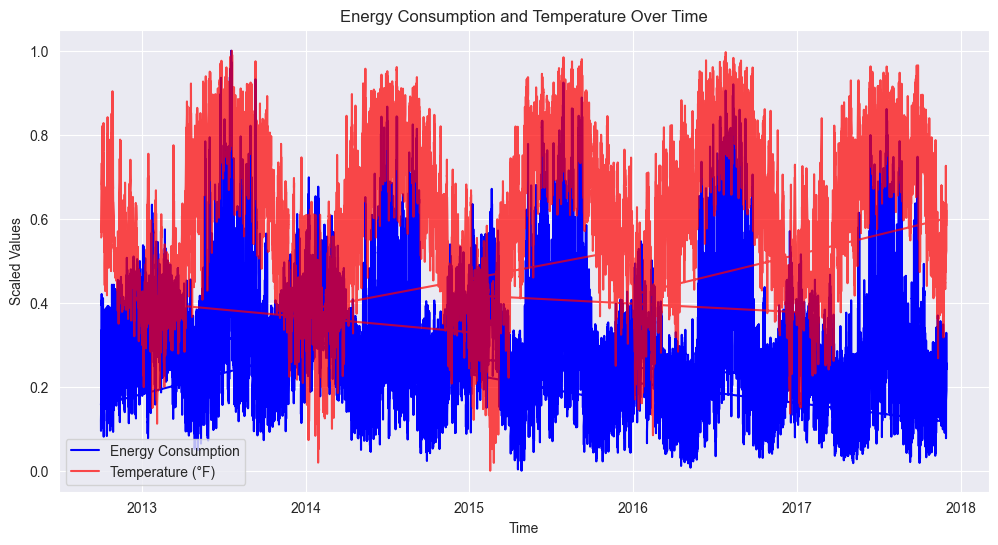

In [29]:
import matplotlib.pyplot as plt

# Plot Energy Consumption and Temperature over time
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Energy_Consumption'], label='Energy Consumption', color='b')
plt.plot(data.index, data['Temperature_F'], label='Temperature (°F)', color='r', alpha=0.7)
plt.title('Energy Consumption and Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('Scaled Values')
plt.legend()
plt.show()




The above graph shows the correlation of energy use and temperature over time. You will notice that they both tend to spike at the same time, in the summer months, when it's hottest. This lends credence to the idea that temperture effects energy consumption.

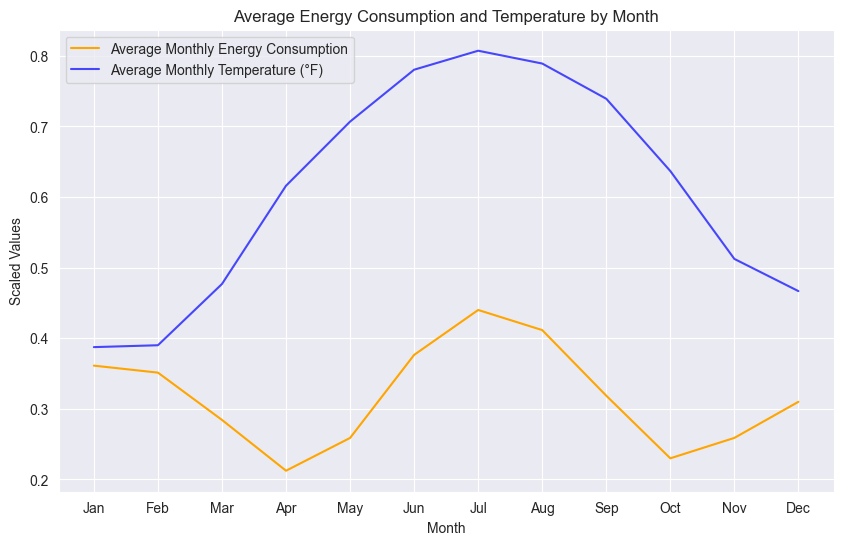

In [31]:
# Group by Month and calculate mean energy consumption and mean temperature
monthly_data = data.groupby('Month')['Energy_Consumption'].mean()
monthly_temperature = data.groupby('Month')['Temperature_F'].mean()

# Plot the monthly energy consumption and temperature pattern
plt.figure(figsize=(10, 6))
plt.plot(monthly_data, label='Average Monthly Energy Consumption', color='orange')
plt.plot(monthly_temperature, label='Average Monthly Temperature (°F)', color='b', alpha=0.7)
plt.title('Average Energy Consumption and Temperature by Month')
plt.xlabel('Month')
plt.ylabel('Scaled Values')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.show()


The above graph shows how both energy consumption and temperature both spike in the warmer months and drop in the moderate to cold ones. This is to be expected if they are related. Also, this only applies to electric energy usage and not other kinds. 

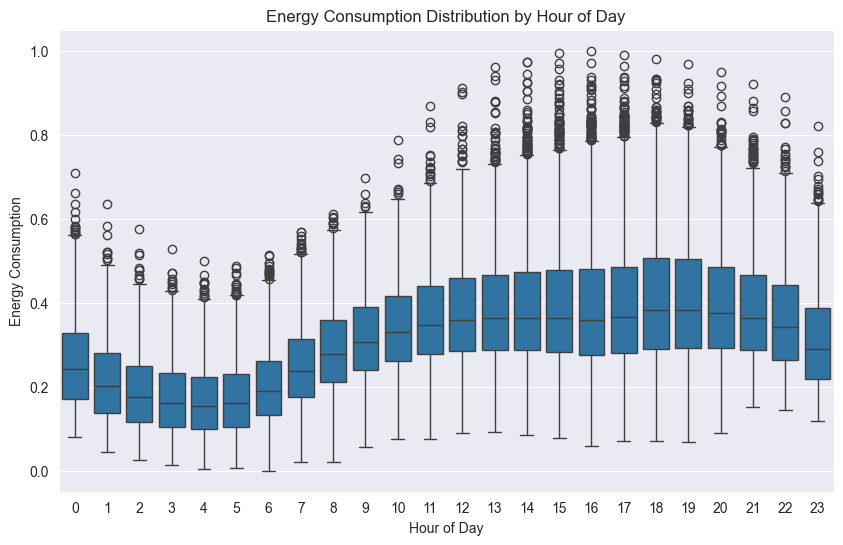

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
# Boxplot for Energy Consumption by Hour
plt.figure(figsize=(10, 6))
sns.boxplot(x='Hour', y='Energy_Consumption', data=data)
plt.title('Energy Consumption Distribution by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Energy Consumption')
plt.show()



The above graphs shows that energy usage is highest during the middle of the day toward the late afternoon and lowest in the late night to early morning. This is later reflected in the widget in the ML energy prediction model. 

The below cell unscales the energy consumption units (megawatts) and the temperature (F) back to normal so they can run through the ML program. We started with a scaled version of the data, and that resulted in a higher overall accuracy, however, it also wasn't possible to properly unscale them afterward and lead to confusing results. We decided to sacrifice a small amount of accuracy for better readability at the end. 

In [3]:
# Unscale the 'Energy_Consumption' and 'Temperature_F' columns using the same scaler
data[['Energy_Consumption', 'Temperature_F']] = scaler.inverse_transform(data[['Energy_Consumption', 'Temperature_F']])



The following cell creates the SQLITE database that the ML model uses to run. The cell after that checks to make sure the database was correctly created and that the data is unscaled.

In [4]:
import sqlite3

# Connect to SQLite database 
conn = sqlite3.connect('energy_consumption.db')  # Name of the database
cursor = conn.cursor()

# Drop the existing table if it exists
cursor.execute('DROP TABLE IF EXISTS energy_consumption')

# Create a table (if it doesn't exist) based on DataFrame columns, including temperature
cursor.execute('''
CREATE TABLE IF NOT EXISTS energy_consumption (
    Date TEXT,
    Energy_Consumption REAL,
    Hour INTEGER,
    Day_of_Week INTEGER,
    Month INTEGER,
    Day INTEGER,
    Season INTEGER,
    Temperature_F REAL
)
''')

# Convert DataFrame to a list of tuples (rows of data)
data_tuples = [tuple(x) for x in data[['Date', 'Energy_Consumption', 'Hour', 'Day_of_Week', 'Month', 'Day', 'Season', 'Temperature_F']].values]

# Insert data into the table
cursor.executemany('''
INSERT INTO energy_consumption (Date, Energy_Consumption, Hour, Day_of_Week, Month, Day, Season, Temperature_F)
VALUES (?, ?, ?, ?, ?, ?, ?, ?)
''', data_tuples)

# Commit the transaction and close the connection
conn.commit()
conn.close()

print("Data inserted successfully.")


Data inserted successfully.


In [5]:
# Reconnect to the database to verify
conn = sqlite3.connect('energy_consumption.db')
cursor = conn.cursor()

# Fetch all data from the table to verify
cursor.execute('SELECT * FROM energy_consumption LIMIT 5')
print(cursor.fetchall())  # Show the first 5 rows of the table

# Close connection
conn.close()


[('2012-12-31', 1556.0, 1, 0, 12, 31, 1, 29.84000000000002), ('2012-12-31', 1509.0, 2, 0, 12, 31, 1, 29.84000000000002), ('2012-12-31', 1479.0, 3, 0, 12, 31, 1, 29.282000000000018), ('2012-12-31', 1468.0, 4, 0, 12, 31, 1, 28.88600000000007), ('2012-12-31', 1488.0, 5, 0, 12, 31, 1, 28.868000000000084)]


The following cell is our ML Energy Prediction model. It runs on Pytorch and uses historical data and advanced feature engineering. The process begins by extracting data from a SQLite database, which includes information on energy consumption, date, time, season, and temperature. After cleaning the data and handling any missing values, the model employs several feature engineering techniques. These include transforming cyclical variables like month and hour into sine and cosine components to capture seasonal trends, creating interaction terms between temperature and hour, and computing a 24-hour rolling average of energy consumption to incorporate recent patterns into the analysis.

We used a neural network architecture that consists of multiple fully connected layers with ReLU activations, which are trained using the Adam optimizer and a learning rate scheduler to minimize the Mean Squared Error (MSE) loss. The training process iterates over several epochs (40), during which the model's performance improves steadily, as indicated by the decreasing loss values. Once trained, we test the model's accuracy by using metrics such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and the R² score. These evaluations demonstrate that the model explains a significant portion of the variance in energy consumption data, which highlights its overall effectiveness.

Below there are also two graphs that showcase the model's predictive accuracy by comparing the actual energy consumption at a given temperature to the program's energy predictions based on a given temperature. 

In addition to the model's predictive capabilities, we added interactive elements to enhance user engagement and facilitate real-time decision-making. At the very bottom is an interactive widget which allows users to input values for temperature, month, and hour, and then receive immediate predictions for energy consumption. 

Epoch 1/40 - Loss: 317014.1065
Epoch 2/40 - Loss: 26724.4454
Epoch 3/40 - Loss: 25777.8530
Epoch 4/40 - Loss: 24832.2559
Epoch 5/40 - Loss: 23909.2422
Epoch 6/40 - Loss: 22961.6504
Epoch 7/40 - Loss: 22000.1398
Epoch 8/40 - Loss: 21050.0420
Epoch 9/40 - Loss: 20100.1595
Epoch 10/40 - Loss: 19389.0367
Epoch 11/40 - Loss: 18836.4509
Epoch 12/40 - Loss: 18774.4580
Epoch 13/40 - Loss: 18716.0469
Epoch 14/40 - Loss: 18672.6403
Epoch 15/40 - Loss: 18619.4540
Epoch 16/40 - Loss: 18560.3524
Epoch 17/40 - Loss: 18513.2119
Epoch 18/40 - Loss: 18458.5082
Epoch 19/40 - Loss: 18418.7912
Epoch 20/40 - Loss: 18382.2336
Epoch 21/40 - Loss: 18340.8866
Epoch 22/40 - Loss: 18326.2533
Epoch 23/40 - Loss: 18321.7614
Epoch 24/40 - Loss: 18318.2156
Epoch 25/40 - Loss: 18318.5093
Epoch 26/40 - Loss: 18306.4078
Epoch 27/40 - Loss: 18304.4303
Epoch 28/40 - Loss: 18300.9973
Epoch 29/40 - Loss: 18297.1678
Epoch 30/40 - Loss: 18290.2394
Epoch 31/40 - Loss: 18286.3524
Epoch 32/40 - Loss: 18284.2084
Epoch 33/40 - Lo

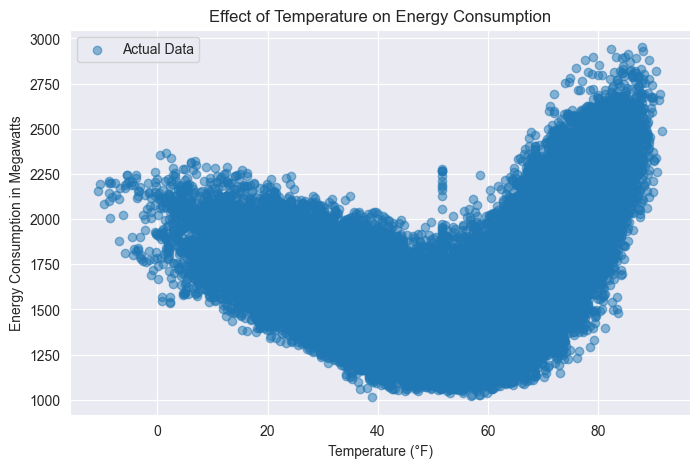


Sample Predictions vs. Actual Energy Consumption:
      Actual Energy  Predicted Energy  Temperature (°F)
0            1604.0       1694.299561            45.824
1            1667.0       1788.638428             5.450
2            1586.0       1508.831055            64.148
3            1866.0       1951.381836             5.090
4            1302.0       1301.928955            45.629
...             ...               ...               ...
9040         1833.0       2071.630371             9.464
9041         1845.0       1784.616577            68.756
9042         1389.0       1411.152466            71.366
9043         1191.0       1331.110718            45.392
9044         1517.0       1454.534424            27.158

[9045 rows x 3 columns]


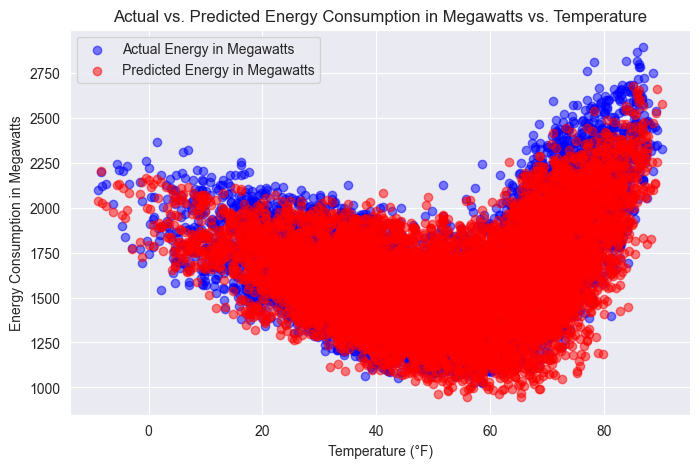

interactive(children=(FloatSlider(value=50.0, description='Temperature (°F):', step=0.5), IntSlider(value=1, d…

In [1]:
import numpy as np
import os
import sqlite3
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import ipywidgets as widgets
from ipywidgets import interactive

# ------------------------------------------------------------------------------
# Data Loading and Preprocessing
# ------------------------------------------------------------------------------

# Connect to the database
conn = sqlite3.connect('energy_consumption.db')
cursor = conn.cursor()

# Fetch the correct columns
cursor.execute('SELECT Date, Energy_Consumption, Hour, Day_of_Week, Month, Day, Season, Temperature_F FROM energy_consumption')
data = cursor.fetchall()
columns = ['Date', 'Energy_Consumption', 'Hour', 'Day_of_Week', 'Month', 'Day', 'Season', 'Temperature_F']

# Convert to DataFrame
df = pd.DataFrame(data, columns=columns)
conn.close()

# Handle missing values
df = df.dropna()

# Feature engineering
#Fourier Transforms for month
df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

# Interaction Term: Temperature_F * Hour
df['Temp_Hour_Interaction'] = df['Temperature_F'] * df['Hour']

# Fourier Transforms for Hour
df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

# Seasonal Feature 
df['Season_numerical'] = df['Season'].map({'Winter': 1, 'Spring': 2, 'Summer': 3, 'Fall': 4})

# Rolling Average of Energy Consumption (24-hour window)
df['Energy_Consumption_rolling_avg'] = df['Energy_Consumption'].rolling(window=24).mean()

# Drop rows with NaN in the rolling average column only
df = df.dropna(subset=['Energy_Consumption_rolling_avg'])


# Select features and target
features = df[['Temperature_F', 'month_sin', 'month_cos', 'Temp_Hour_Interaction', 'hour_sin', 'hour_cos', 'Energy_Consumption_rolling_avg']].values
target = df['Energy_Consumption'].values


#  Perform train-test split before converting to PyTorch tensors
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

# Create DataLoader for training
dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# ------------------------------------------------------------------------------
# Define the Neural Network Model
# ------------------------------------------------------------------------------

# Define the Neural Network 
class EnergyPredictionNN(nn.Module):
    def __init__(self):
        super(EnergyPredictionNN, self).__init__()
        self.fc1 = nn.Linear(7, 64)  # 7 features now: Temperature_F, month_sin, month_cos, Temp_Hour_Interaction, hour_sin, hour_cos, Energy_Consumption_rolling_avg
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the model
model = EnergyPredictionNN()

# File path for saving the model
model_file = "model.pth"

# ------------------------------------------------------------------------------
# Load or Train the Model
# ------------------------------------------------------------------------------

FORCE_TRAIN = True  # Set to True to retrain even if a saved model exists
# Load saved model
if os.path.exists(model_file) and not FORCE_TRAIN:
    model.load_state_dict(torch.load(model_file, weights_only=True))
    model.eval()
    print("Model loaded successfully from", model_file)
else:
    # Set up optimizer and learning rate scheduler
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    # Training loop
    for epoch in range(40):
        model.train()
        total_loss = 0
        for features_batch, target_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(features_batch)
            loss = nn.MSELoss()(predictions, target_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        print(f"Epoch {epoch+1}/40 - Loss: {total_loss / len(train_loader):.4f}")
    
    # Save the trained model
    torch.save(model.state_dict(), model_file)
    print("Model trained and saved successfully to", model_file)

# ------------------------------------------------------------------------------
# Evaluation on Test Data
# ------------------------------------------------------------------------------

# Convert test data to PyTorch tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Generate predictions for the test set
model.eval()  # Ensure evaluation mode
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

y_pred = y_pred_tensor.numpy().flatten()

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

print("\nModel Performance Summary:")
print(f"The model explains {r2 * 100:.2f}% of the variation in energy consumption.")
print(f"On average, predictions are off by {mae:.4f} units of energy consumption.")
print(f"The model's RMSE is {rmse:.4f}, meaning most errors are within this range.")

# ------------------------------------------------------------------------------
# Create a Scatter Plot of Prediction vs Actual Energy Consumption
# ------------------------------------------------------------------------------

import matplotlib.pyplot as plt

# Scatter plot to show relationship
plt.figure(figsize=(8, 5))
plt.scatter(df['Temperature_F'], df['Energy_Consumption'], alpha=0.5, label="Actual Data")
plt.xlabel("Temperature (°F)")
plt.ylabel("Energy Consumption in Megawatts")
plt.title("Effect of Temperature on Energy Consumption")
plt.legend()
plt.show()

# Convert y_pred to 1D array
y_pred = y_pred.flatten()

# Ensure everything has the same length
num_samples = min(len(y_test), len(y_pred), X_test.shape[0])

comparison_df = pd.DataFrame({
    'Actual Energy': y_test[:num_samples], 
    'Predicted Energy': y_pred[:num_samples], 
    'Temperature (°F)': X_test[:num_samples, 0]  
})

print("\nSample Predictions vs. Actual Energy Consumption:")
print(comparison_df)

# Scatter plot comparing actual vs. predicted energy consumption
plt.figure(figsize=(8, 5))

# Plot actual data
plt.scatter(comparison_df['Temperature (°F)'], comparison_df['Actual Energy'], 
            alpha=0.5, label="Actual Energy in Megawatts", color='blue')

# Plot predicted data
plt.scatter(comparison_df['Temperature (°F)'], comparison_df['Predicted Energy'], 
            alpha=0.5, label="Predicted Energy in Megawatts", color='red')

plt.xlabel("Temperature (°F)")
plt.ylabel("Energy Consumption in Megawatts")
plt.title("Actual vs. Predicted Energy Consumption in Megawatts vs. Temperature")
plt.legend()
plt.show()

# ------------------------------------------------------------------------------
# Define the Energy Prediction Function
# ------------------------------------------------------------------------------

def predict_energy(temperature_F, month, hour, rolling_avg):
   
    # Compute Fourier features and interaction term
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)
    temp_hour_interaction = temperature_F * hour
    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)
    
    # Combine features into a NumPy array 
    input_features = np.array([
        temperature_F, 
        month_sin, 
        month_cos, 
        temp_hour_interaction, 
        hour_sin, 
        hour_cos, 
        rolling_avg
    ], dtype=np.float32)
    
    # Convert features to a tensor and add batch dimension
    input_tensor = torch.tensor(input_features).unsqueeze(0)
    
    # Predict energy consumption
    with torch.no_grad():
        prediction = model(input_tensor)
    
    # Return the prediction as a scalar value
    return prediction.item()

# ------------------------------------------------------------------------------
# Create an Interactive Widget for Temperature, Month, and Hour Input
# ------------------------------------------------------------------------------

def interactive_prediction(temperature_F, month, hour):
   
    # Compute a default rolling average from the dataset 
    default_rolling_avg = df['Energy_Consumption_rolling_avg'].mean()
    
    # Get the predicted energy consumption
    predicted_value = predict_energy(temperature_F, month, hour, default_rolling_avg)
    print(f"Predicted Energy Consumption:\n"
          f"  Temperature: {temperature_F}°F\n"
          f"  Month: {month}\n"
          f"  Hour: {hour}\n"
          f"  (Rolling Avg: {default_rolling_avg:.2f})\n"
          f"→ {predicted_value:.4f} (in megawatts)")

# Create interactive widgets for temperature, month, and hour
temp_slider = widgets.FloatSlider(min=0, max=100, step=0.5, value=50, description='Temperature (°F):')
month_slider = widgets.IntSlider(min=1, max=12, step=1, value=1, description='Month:')
hour_slider = widgets.IntSlider(min=0, max=23, step=1, value=12, description='Hour:')

# Link the interactive function to the widgets
interactive(interactive_prediction, temperature_F=temp_slider, month=month_slider, hour=hour_slider)



If you utilize the above widget you can see for yourself the real-time energy prediction model works as we thought it would.